In [39]:
# ! pip install xarray cfgrib eccodes --quiet

In [1]:
import duckdb
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMapWithTime

from sklearn.neighbors import BallTree

pd.set_option('display.max_columns', None)

In [2]:
con = duckdb.connect('/network/scratch/g/guzmand/Fall-2025/COMP-685-ML-for-Climate-Change/data/iNaturalist.duckdb')
print("connected!")

connected!


In [3]:
# List all tables
tables = con.execute("SHOW TABLES").fetchdf()
print(tables)

                       name
0                ERA5_Daily
1                 era5_grid
2               iNaturalist
3  iNaturalist_grid_mapping


# Data

## iNaturalist joined with ERA5
The idea is that for a given observation with (latitude, longitude, time) we can join this with the ERA5 dataset to get relevant climate features for that specific place and time. 

Our proposed framework integrates spatial and temporal information through location and time encoders, or an LLM, to produce joint spatio-temporal embeddings for downstream climate related prediction tasks

- **Location Encoder:** A pretrained geographic encoder $f_{loc}$ like SatCLIP transforms coordinates into dense location embeddings $\mathbf{z}_{\text{loc}} = f_{\text{loc}}(\text{lat}, \text{long})$.
- **Time Encoder:** Given a relevant climate time series with $n$ observations (e.g., temperature, precipitation, wind) at a given location and time $x_{t} = (x_{t_{0}}, x_{t_{1}}, \ldots, x_{t_{n}})$, where each $x_{t_{i}}$ represents the value at time step $t_{i}$. This sequence is passed through the time encoder $f_{\text{time}}$, like TimesFM to produce a fixed length embedding $\mathbf{z}_{\text{time}} = f_{\text{time}}(x_{t})$.
- **Downstream Tasks:** The joint embeddings feed task specific predictors for applications where spatio-temporal data is relevant. For instance, in species distribution modeling, the embeddings could help predict how suitable habitats shift under changing temperature and precipitation regimes, offering insights for biodiversity conservation.

![Location-Time Encoders](../images/location-time-encoders.jpg)

These are the variables in the ERA5 dataset

```python
era5_variable_names = {
    "u10": "10m u-component of wind",
    "v10": "10m v-component of wind",
    "d2m": "2m dewpoint temperature",
    "t2m": "2m temperature",
    "msl": "Mean sea level pressure",
    "mwd": "Mean wave direction",
    "mwp": "Mean wave period",
    "sst": "Sea surface temperature",
    "swh": "Significant height of combined wind waves and swell",
    "sp": "Surface pressure",
    "tp": "Total precipitation"
}
```

### Daily
The resulting dataframe provides species + climate data aligned at the **daily** level. From here, it can be aggregated further, for example, by week, month, or by ERA5 grid cell.

1. Filter observations of by species, date, location, and valid coordinates.
2. Map each observation to its nearest ERA5 grid cell.
3. Extract a 7-day climate history (the observation day + previous 6 days) for each ERA5 grid cell, using a window function over ERA5 daily reanalysis variables (e.g., temperature, precipitation, wind).
4. Join iNaturalist + ERA5 so each biological observation has geographic metadata, its mapped grid-cell coordinates, a set of short climate histories (arrays) for each variable.



In [4]:
verbatimScientificName = "Danaus plexippus"
min_date = "2020-01-01"
max_date = "2025-12-31"

query = f"""
-- This can be grouped further
SELECT *
FROM ERA5_grid;
"""
df = con.execute(query).df()
# Remove a few of the first days that don't have 7-days histories (I didn't get 2019 data)
df

,latitude,longitude,grid_id
0,-90.0,0.00,0
1,-90.0,0.25,1
2,-90.0,0.50,2
3,-90.0,0.75,3
4,-90.0,1.00,4
...,...,...,...
1038235,90.0,358.75,1038235
1038236,90.0,359.00,1038236
1038237,90.0,359.25,1038237
1038238,90.0,359.50,1038238


In [5]:
verbatimScientificName = "Danaus plexippus"
min_date = "2020-01-01"
max_date = "2025-12-31"

query = f"""
WITH filtered_iNaturalist AS (
    SELECT
        gbifID,
        verbatimScientificName,
        STRFTIME(
            TRY_STRPTIME(eventDate, ['%Y-%m-%dT%H:%M:%S', '%Y-%m-%dT%H:%M', '%Y-%m-%d']),
            '%Y-%m-%d'
        ) AS dateOcurrence,  -- keep only the date part
        decimalLatitude,
        decimalLongitude,
        countryCode
    FROM iNaturalist
    WHERE
        decimalLatitude IS NOT NULL
        AND decimalLongitude IS NOT NULL
        AND eventDate IS NOT NULL AND TRIM(eventDate) <> '' 
        AND dateOcurrence IS NOT NULL AND TRIM(dateOcurrence) <> ''
        AND TRY_STRPTIME(eventDate, ['%Y-%m-%dT%H:%M:%S', '%Y-%m-%dT%H:%M', '%Y-%m-%d']) BETWEEN '{min_date}' AND '{max_date}'
        AND verbatimScientificName = '{verbatimScientificName}'
        AND countryCode IN ('US', 'CA', 'MX')
),

mapped_iNaturalist AS (
    SELECT
        filtered_iNaturalist.verbatimScientificName,
        CAST(filtered_iNaturalist.dateOcurrence AS DATE) AS dateOcurrence,
        filtered_iNaturalist.decimalLatitude,
        filtered_iNaturalist.decimalLongitude,
        filtered_iNaturalist.countryCode,
        iNaturalist_grid_mapping.nearest_grid_id,
        1 AS countOccurrences,
    FROM filtered_iNaturalist AS filtered_iNaturalist
    JOIN iNaturalist_grid_mapping AS iNaturalist_grid_mapping
    USING (gbifID)
),

mapped_ERA5 AS (
    SELECT
        CAST(ERA5_Daily.valid_time AS DATE) AS valid_time,
        ERA5_Daily.latitude,
        ERA5_Daily.longitude,
        ERA5_grid.grid_id,
        -- Build the array of 7 historical + current values (ordered by date)
        LIST(u10) OVER w AS u10_hist,
        LIST(v10) OVER w AS v10_hist,
        LIST(d2m) OVER w AS d2m_hist,
        LIST(t2m) OVER w AS t2m_hist,
        LIST(msl) OVER w AS msl_hist,
        LIST(mwd) OVER w AS mwd_hist,
        LIST(mwp) OVER w AS mwp_hist,
        LIST(sst) OVER w AS sst_hist,
        LIST(swh) OVER w AS swh_hist,
        LIST(sp)  OVER w AS sp_hist,
        LIST(tp)  OVER w AS tp_hist

    FROM ERA5_Daily
    JOIN ERA5_grid 
      ON ERA5_Daily.latitude = ERA5_grid.latitude
     AND ERA5_Daily.longitude = ERA5_grid.longitude
    WHERE
        valid_time BETWEEN '{min_date}' AND '{max_date}'
        AND ERA5_grid.grid_id IN (
            SELECT DISTINCT nearest_grid_id
            FROM mapped_iNaturalist
        )

    WINDOW w AS (
        PARTITION BY grid_id
        ORDER BY valid_time
        -- This gets the last 6 days before valid_time and the current valid_time
        ROWS BETWEEN 6 PRECEDING AND CURRENT ROW
    )
),

joined_iNaturalist_ERA5 AS (
    SELECT
        mapped_iNaturalist.verbatimScientificName,
        mapped_iNaturalist.dateOcurrence,
        mapped_iNaturalist.decimalLatitude,
        mapped_iNaturalist.decimalLongitude,
        mapped_iNaturalist.countryCode,
        mapped_iNaturalist.nearest_grid_id,
        mapped_iNaturalist.countOccurrences,
        mapped_ERA5.latitude AS nearest_grid_id_latitude,
        mapped_ERA5.longitude AS nearest_grid_id_longitude,
        mapped_ERA5.u10_hist,
        mapped_ERA5.v10_hist,
        mapped_ERA5.d2m_hist,
        mapped_ERA5.t2m_hist,
        mapped_ERA5.msl_hist,
        -- mapped_ERA5.mwd_hist, -- these are sea variables, so they appear as NaN on the land
        -- mapped_ERA5.mwp_hist, -- these are sea variables, so they appear as NaN on the land
        -- mapped_ERA5.sst_hist, -- these are sea variables, so they appear as NaN on the land
        -- mapped_ERA5.swh_hist, -- these are sea variables, so they appear as NaN on the land
        mapped_ERA5.sp_hist,
        mapped_ERA5.tp_hist
    FROM mapped_iNaturalist AS mapped_iNaturalist
    JOIN mapped_ERA5 AS mapped_ERA5
      ON mapped_iNaturalist.nearest_grid_id = mapped_ERA5.grid_id
      AND mapped_iNaturalist.dateOcurrence = mapped_ERA5.valid_time
)


-- This can be grouped further
SELECT *
FROM joined_iNaturalist_ERA5
ORDER BY dateOcurrence, decimalLatitude, decimalLongitude;
"""
df = con.execute(query).df()
# Remove a few of the first days that don't have 7-days histories (I didn't get 2019 data)
df = df[df["u10_hist"].apply(len) == 7]
df

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,verbatimScientificName,dateOcurrence,decimalLatitude,decimalLongitude,countryCode,nearest_grid_id,countOccurrences,nearest_grid_id_latitude,nearest_grid_id_longitude,u10_hist,v10_hist,d2m_hist,t2m_hist,msl_hist,sp_hist,tp_hist
79,Danaus plexippus,2020-01-07,23.299000,-106.443000,MX,653334,1,23.25,253.50,"[-1.1912784576416016, 0.21049053966999054, 1.2...","[0.41495323181152344, 1.2509905099868774, -2.6...","[290.542724609375, 288.5713195800781, 287.7474...","[293.4073791503906, 292.4245910644531, 293.499...","[101282.4296875, 101193.3359375, 101573.125, 1...","[101399.7109375, 101310.8671875, 101690.65625,...","[0.002592881442978978, 0.0005121827125549316, ..."
80,Danaus plexippus,2020-01-07,26.181973,-80.125923,US,670719,1,26.25,279.75,"[-0.017206192016601562, -1.9012037515640259, -...","[-1.6698856353759766, 0.740899384021759, 4.106...","[284.07568359375, 289.0439758300781, 293.88439...","[292.7335510253906, 294.84197998046875, 298.45...","[101772.5625, 101783.7734375, 101789.1875, 101...","[101704.1640625, 101715.6171875, 101721.242187...","[0.0, 0.0, 9.934107083608978e-07, 2.0364919691..."
81,Danaus plexippus,2020-01-07,28.658221,-81.386191,US,685114,1,28.75,278.50,"[1.2142391204833984, -1.514200210571289, -0.46...","[-1.1532840728759766, 1.1368547677993774, 3.67...","[278.1405334472656, 283.8645935058594, 292.412...","[287.3736877441406, 290.4765930175781, 296.133...","[101860.5, 101795.4140625, 101669.6953125, 101...","[101541.1640625, 101479.78125, 101356.28125, 1...","[0.0, 0.0, 7.669131264265161e-06, 0.0005294680..."
82,Danaus plexippus,2020-01-07,29.301348,-94.797696,US,687941,1,29.25,265.25,"[-2.520827531814575, -1.0590814352035522, 1.34...","[1.1612911224365234, 2.0519344806671143, 1.262...","[279.368896484375, 289.3843688964844, 288.0708...","[287.8973693847656, 290.4136047363281, 290.024...","[101831.03125, 100682.0859375, 100917.65625, 1...","[101813.375, 100664.90625, 100900.40625, 10236...","[2.2470951080322266e-05, 0.0011809667339548469..."
83,Danaus plexippus,2020-01-07,29.892725,-95.514687,US,692258,1,30.00,264.50,"[-0.6443220973014832, -0.6580397486686707, 1.8...","[1.1187292337417603, 1.9181455373764038, 0.027...","[275.7267150878906, 287.5146789550781, 284.863...","[284.8507385253906, 288.4826965332031, 287.952...","[101817.625, 100664.2734375, 100910.9453125, 1...","[101321.0, 100177.28125, 100423.3671875, 10193...","[8.960564628068823e-06, 0.0007939140195958316,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216526,Danaus plexippus,2025-10-21,40.526402,-74.495054,US,752822,1,40.50,285.50,"[1.1629976034164429, 1.8447412252426147, 1.530...","[-2.919408082962036, -4.02459192276001, -3.113...","[283.3708801269531, 271.6748352050781, 271.023...","[289.5272521972656, 285.1553955078125, 284.869...","[101545.7421875, 101466.5546875, 101552.40625,...","[100885.0625, 100796.3359375, 100882.1328125, ...","[4.5696893380409165e-07, 0.0, 0.0, 1.293420791..."
216527,Danaus plexippus,2025-10-21,40.860142,-73.933889,US,754264,1,40.75,286.00,"[0.9071788787841797, 1.8905582427978516, 1.594...","[-3.163426637649536, -4.165746212005615, -3.67...","[284.5069274902344, 275.7417907714844, 275.066...","[289.0607604980469, 285.3655090332031, 285.286...","[101516.6875, 101412.7109375, 101498.9296875, ...","[101297.1484375, 101190.0, 101276.4296875, 101...","[2.702077154026483e-06, 0.0, 0.0, 5.3445496632..."
216528,Danaus plexippus,2025-10-21,40.861013,-73.879937,US,754264,1,40.75,286.00,"[0.9071788787841797, 1.8905582427978516, 1.594...","[-3.163426637649536, -4.165746212005615, -3.67...","[284.5069274902344, 275.7417907714844, 275.066...","[289.0607604980469, 285.3655090332031, 285.286...","[101516.6875, 101412.7109375, 101498.9296875, ...","[101297.1484375, 101190.0, 101276.4296875, 101...","[2.702077154026483e-06, 0.0, 0.0, 5.3445496632..."
216529,Danaus plexippus,2025-10-21,40.890367,-73.897522,US,755704,1,41.00,286.00,"[0.9740734100341797, 1.8374576568603516, 1.531...","[-3.212946653366089, -4.07594

#### Aggregating by `dateOcurrence` and `nearest_grid_id`

We can group the data by `dateOcurrence` and `nearest_grid_id` to keep a daily resolution while combining all observations within the same grid cell into a single aggregated record.

In [6]:
cols = [
    "dateOcurrence",
    "nearest_grid_id",
    "nearest_grid_id_latitude",
    "nearest_grid_id_longitude",
    "decimalLatitude",
    "decimalLongitude",
    "countryCode",
    "verbatimScientificName",
    "countOccurrences",
    "u10_hist",
    "v10_hist",
    "d2m_hist",
    "t2m_hist",
    "msl_hist",
    "sp_hist",
    "tp_hist",
]

# Sort so that "most recent" means "last" in each group
df = df.sort_values("dateOcurrence")

agg_df = (
    df.groupby(["dateOcurrence", "nearest_grid_id"], as_index=False)
      .agg({
          "countOccurrences": "sum",
          "verbatimScientificName": list,
          "decimalLatitude": list,
          "decimalLongitude": list,
          "countryCode": list,
          "nearest_grid_id_latitude": "last",
          "nearest_grid_id_longitude": "last",
          "u10_hist": "last",
          "v10_hist": "last",
          "d2m_hist": "last",
          "t2m_hist": "last",
          "msl_hist": "last",
          "sp_hist": "last",
          "tp_hist": "last",
      })
)
agg_df = agg_df[cols]
agg_df

,dateOcurrence,nearest_grid_id,nearest_grid_id_latitude,nearest_grid_id_longitude,decimalLatitude,decimalLongitude,countryCode,verbatimScientificName,countOccurrences,u10_hist,v10_hist,d2m_hist,t2m_hist,msl_hist,sp_hist,tp_hist
0,2020-01-07,653334,23.25,253.50,[23.299],[-106.443],[MX],[Danaus plexippus],1,"[-1.1912784576416016, 0.21049053966999054, 1.2...","[0.41495323181152344, 1.2509905099868774, -2.6...","[290.542724609375, 288.5713195800781, 287.7474...","[293.4073791503906, 292.4245910644531, 293.499...","[101282.4296875, 101193.3359375, 101573.125, 1...","[101399.7109375, 101310.8671875, 101690.65625,...","[0.002592881442978978, 0.0005121827125549316, ..."
1,2020-01-07,670719,26.25,279.75,[26.181973],[-80.125923],[US],[Danaus plexippus],1,"[-0.017206192016601562, -1.9012037515640259, -...","[-1.6698856353759766, 0.740899384021759, 4.106...","[284.07568359375, 289.0439758300781, 293.88439...","[292.7335510253906, 294.84197998046875, 298.45...","[101772.5625, 101783.7734375, 101789.1875, 101...","[101704.1640625, 101715.6171875, 101721.242187...","[0.0, 0.0, 9.934107083608978e-07, 2.0364919691..."
2,2020-01-07,685114,28.75,278.50,[28.658221],[-81.386191],[US],[Danaus plexippus],1,"[1.2142391204833984, -1.514200210571289, -0.46...","[-1.1532840728759766, 1.1368547677993774, 3.67...","[278.1405334472656, 283.8645935058594, 292.412...","[287.3736877441406, 290.4765930175781, 296.133...","[101860.5, 101795.4140625, 101669.6953125, 101...","[101541.1640625, 101479.78125, 101356.28125, 1...","[0.0, 0.0, 7.669131264265161e-06, 0.0005294680..."
3,2020-01-07,687941,29.25,265.25,[29.301348],[-94.797696],[US],[Danaus plexippus],1,"[-2.520827531814575, -1.0590814352035522, 1.34...","[1.1612911224365234, 2.0519344806671143, 1.262...","[279.368896484375, 289.3843688964844, 288.0708...","[287.8973693847656, 290.4136047363281, 290.024...","[101831.03125, 100682.0859375, 100917.65625, 1...","[101813.375, 100664.90625, 100900.40625, 10236...","[2.2470951080322266e-05, 0.0011809667339548469..."
4,2020-01-07,692258,30.00,264.50,[29.892725],[-95.514687],[US],[Danaus plexippus],1,"[-0.6443220973014832, -0.6580397486686707, 1.8...","[1.1187292337417603, 1.9181455373764038, 0.027...","[275.7267150878906, 287.5146789550781, 284.863...","[284.8507385253906, 288.4826965332031, 287.952...","[101817.625, 100664.2734375, 100910.9453125, 1...","[101321.0, 100177.28125, 100423.3671875, 10193...","[8.960564628068823e-06, 0.0007939140195958316,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149729,2025-10-21,751348,40.25,277.00,[40.136439],[-83.034339],[US],[Danaus plexippus],1,"[-0.4459705352783203, -0.43085289001464844, -1...","[-2.534479856491089, -2.340550661087036, 1.210...","[282.84564208984375, 279.03533935546875, 276.3...","[286.7170104980469, 285.0031433105469, 283.512...","[102305.53125, 102207.5625, 101895.75, 101178....","[98751.2734375, 98631.9140625, 98333.4140625, ...","[0.0, 0.0, 0.0, 1.7881393432617188e-07, 0.0009..."
149730,2025-10-21,752822,40.50,285.50,[40.526402],[-74.495054],[US],[Danaus plexippus],1,"[1.1629976034164429, 1.8447412252426147, 1.530...","[-2.919408082962036, -4.02459192276001, -3.113...","[283.3708801269531, 271.6748352050781, 271.023...","[289.5272521972656, 285.1553955078125, 284.869...","[101545.7421875, 101466.5546875, 101552.40625,...","[100885.0625, 100796.3359375, 100882.1328125, ...","[4.5696893380409165e-07, 0.0, 0.0, 1.293420791..."
149731,2025-10-21,754264,40.75,286.00,"[40.860142, 40.861013]","[-73.933889, -73.879937]","[US, US]","[Danaus plexippus, Danaus plexippus]",2,"[0.9071788787841797, 1.8905582427978516, 1.594...","[-3.163426637649536, -4.165746212005615, -3.67...","[284.5069274902344, 275.7417907714844, 275.066...","[289.0607604980469, 285.3655090332031, 285.286...","[101516.6875, 101412.7109375, 101498.9296875, ...","[101297.1484375, 101190.0, 101276.4296875, 101...","[2.702077154026483e-06, 0.0, 0.0, 5.3445496632..."
149732,2025-10-21,755704,41.00,286.00,[40.890367],[-73.89

#### Aggregating by `year_week` and `nearest_grid_id`

We can group the data by `year_week` and `nearest_grid_id` to produce weekly aggregated records, combining all observations within the same grid cell for each week.

In [7]:
cols = [
    "year_week",
    "dateOcurrence",
    "nearest_grid_id",
    "nearest_grid_id_latitude",
    "nearest_grid_id_longitude",
    "decimalLatitude",
    "decimalLongitude",
    "countryCode",
    "verbatimScientificName",
    "countOccurrences",
    "u10_hist",
    "v10_hist",
    "d2m_hist",
    "t2m_hist",
    "msl_hist",
    "sp_hist",
    "tp_hist",
]

df["dateOcurrence"] = pd.to_datetime(df["dateOcurrence"])

# Create a week-of-year column
iso = df["dateOcurrence"].dt.isocalendar()
df["year_week"] = iso["year"].astype(str) + "-" + iso["week"].astype(str).str.zfill(2)


# Sort so that "most recent" means "last" in each group
df = df.sort_values("dateOcurrence")

agg_df = (
    df
    .groupby(["year_week", "nearest_grid_id"], as_index=False)
    .agg({
          "countOccurrences": "sum",
          "verbatimScientificName": list,
          "dateOcurrence": list,
          "decimalLatitude": list,
          "decimalLongitude": list,
          "countryCode": list,
          "nearest_grid_id_latitude": "last",
          "nearest_grid_id_longitude": "last",
          "u10_hist": "last",
          "v10_hist": "last",
          "d2m_hist": "last",
          "t2m_hist": "last",
          "msl_hist": "last",
          "sp_hist": "last",
          "tp_hist": "last",
      }
    )
)
agg_df = agg_df[cols]
agg_df

,year_week,dateOcurrence,nearest_grid_id,nearest_grid_id_latitude,nearest_grid_id_longitude,decimalLatitude,decimalLongitude,countryCode,verbatimScientificName,countOccurrences,u10_hist,v10_hist,d2m_hist,t2m_hist,msl_hist,sp_hist,tp_hist
0,2020-02,[2020-01-11 00:00:00],630319,19.25,259.75,[19.365011],[-100.294392],[MX],[Danaus plexippus],1,"[-1.0488017797470093, -0.05954424664378166, -0...","[-0.7950083613395691, -0.10547828674316406, -0...","[277.2191162109375, 278.2710876464844, 278.051...","[287.4580078125, 286.6080322265625, 287.080383...","[102147.8671875, 102011.0234375, 101841.585937...","[81491.2578125, 81391.2578125, 81291.4609375, ...","[0.0, 0.0, 0.0, 2.5510787963867188e-05, 0.0, 0..."
1,2020-02,[2020-01-11 00:00:00],634637,20.00,259.25,[20.040089],[-100.723572],[MX],[Danaus plexippus],1,"[-0.8755432963371277, -0.027887344360351562, -...","[-1.1186574697494507, -0.17933082580566406, -0...","[272.2959289550781, 272.7549743652344, 272.618...","[284.0393981933594, 285.5241394042969, 286.964...","[102507.4296875, 102084.5234375, 101964.25, 10...","[79458.7578125, 79265.7578125, 79213.4140625, ...","[0.0, 0.0, 0.0, 5.086263172415784e-06, 2.66234..."
2,2020-02,"[2020-01-08 00:00:00, 2020-01-12 00:00:00]",641828,21.25,257.00,"[21.176591, 21.176591]","[-102.885647, -102.885647]","[MX, MX]","[Danaus plexippus, Danaus plexippus]",2,"[-0.26393064856529236, -1.13653564453125, -1.0...","[-0.5435479283332825, -0.4225482940673828, -0....","[268.4554748535156, 271.5700988769531, 272.906...","[286.1736145019531, 288.9594421386719, 287.138...","[102131.5234375, 101938.2578125, 102136.054687...","[83103.6796875, 83002.4609375, 83058.171875, 8...","[0.0, 1.748402951307071e-06, 0.0, 0.0, 0.0, 0...."
3,2020-02,[2020-01-08 00:00:00],643048,21.50,202.00,[21.414412],[-157.995773],[US],[Danaus plexippus],1,"[-1.0943189859390259, -4.930917263031006, -6.1...","[-1.8201357126235962, -3.709315061569214, -3.1...","[291.8149719238281, 292.3414001464844, 293.161...","[295.3735046386719, 295.2958984375, 296.111022...","[101708.8125, 101965.5703125, 102216.2890625, ...","[99818.7421875, 100069.03125, 100316.5703125, ...","[7.512172305723652e-05, 0.00014152129006106406..."
4,2020-02,[2020-01-07 00:00:00],653334,23.25,253.50,[23.299],[-106.443],[MX],[Danaus plexippus],1,"[-1.1912784576416016, 0.21049053966999054, 1.2...","[0.41495323181152344, 1.2509905099868774, -2.6...","[290.542724609375, 288.5713195800781, 287.7474...","[293.4073791503906, 292.4245910644531, 293.499...","[101282.4296875, 101193.3359375, 101573.125, 1...","[101399.7109375, 101310.8671875, 101690.65625,...","[0.002592881442978978, 0.0005121827125549316, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97968,2025-43,[2025-10-20 00:00:00],761410,42.00,272.50,[41.876287],[-87.621453],[US],[Danaus plexippus],1,"[-1.2621809244155884, -4.351569652557373, -3.0...","[-4.027459621429443, -4.1240386962890625, 0.73...","[287.65985107421875, 284.39691162109375, 283.4...","[290.7469787597656, 288.3119812011719, 288.462...","[102407.15625, 102455.9609375, 102223.5703125,...","[100352.1171875, 100384.0234375, 100160.085937...","[3.97364289028701e-07, 0.00011267264926573262,..."
97969,2025-43,[2025-10-20 00:00:00],765736,42.75,274.00,[42.776813],[-86.112511],[US],[Danaus plexippus],1,"[-0.026056289672851562, -1.3848539590835571, -...","[-2.3010189533233643, -1.8972727060317993, 0.4...","[285.6966247558594, 279.8614196777344, 279.088...","[289.67333984375, 287.0600280761719, 285.29724...","[102378.7890625, 102504.6171875, 102303.570312...","[99964.2421875, 100064.9375, 99866.0859375, 99...","[0.0, 2.4100145310512744e-05, 0.0, 1.112619997..."
97970,2025-43,[2025-10-20 00:00:00],765755,42.75,278.75,[42.664597],[-81.169833],[CA],[Danaus plexippus],1,"[-0.28692054748535156, 0.8823986053466797, 0.0...","[-2.7191097736358643, -4.3059234619140625, -3....","[283.4685974121094, 279.7908630371094, 275.803...","[287.33642578125, 285.7005920410156, 282.91296...","[102270.1953125, 1023

##### Aggregating by further by binning grids


In [15]:
query = f"""
SELECT *
FROM ERA5_grid;
"""
ERA5_grid = con.execute(query).df()

# Choose your bin size (in degrees)
BIN_SIZE = 1.0

# Create binned latitude and longitude (bin centers)
# We use floor division to assign each point to a bin, then calculate the center
ERA5_grid['binned_grid_id_latitude'] = (np.floor(ERA5_grid['latitude'] / BIN_SIZE) * BIN_SIZE + BIN_SIZE / 2)
ERA5_grid['binned_grid_id_longitude'] = (np.floor(ERA5_grid['longitude'] / BIN_SIZE) * BIN_SIZE + BIN_SIZE / 2)

# Create a unique binned_grid_id based on the binned coordinates
# Method 1: Using a combination of lat and lon to create unique IDs
ERA5_grid['binned_grid_id'] = ERA5_grid.groupby(
    ['binned_grid_id_latitude', 'binned_grid_id_longitude']
).ngroup()

ERA5_bins = ERA5_grid.sort_values(by=["binned_grid_id", "binned_grid_id_latitude", "binned_grid_id_longitude"]).reset_index(drop=True)
ERA5_bins.head(20)

,latitude,longitude,grid_id,binned_grid_id_latitude,binned_grid_id_longitude,binned_grid_id
0,-90.00,0.00,0,-89.5,0.5,0
1,-90.00,0.25,1,-89.5,0.5,0
2,-90.00,0.50,2,-89.5,0.5,0
3,-90.00,0.75,3,-89.5,0.5,0
4,-89.75,0.00,1440,-89.5,0.5,0
5,-89.75,0.25,1441,-89.5,0.5,0
6,-89.75,0.50,1442,-89.5,0.5,0
7,-89.75,0.75,1443,-89.5,0.5,0
8,-89.50,0.00,2880,-89.5,0.5,0
9,-89.50,0.25,2881,-89.5,0.5,0


In [16]:
cols = [
    "year_week",
    "dateOcurrence",
    "binned_grid_id",
    "binned_grid_id_latitude",
    "binned_grid_id_longitude",
    "decimalLatitude",
    "decimalLongitude",
    "countryCode",
    "verbatimScientificName",
    "countOccurrences",
    "u10_hist",
    "v10_hist",
    "d2m_hist",
    "t2m_hist",
    "msl_hist",
    "sp_hist",
    "tp_hist",
]

agg_df_binned = agg_df.merge(
    ERA5_grid[['grid_id', 'binned_grid_id', 'binned_grid_id_latitude', 'binned_grid_id_longitude']],
    left_on='nearest_grid_id',
    right_on='grid_id',
    how='left'
)

agg_df_binned = (
    agg_df_binned
    .groupby(["year_week", "binned_grid_id"], as_index=False)
    .agg({
          "countOccurrences": "sum",
          "verbatimScientificName": list,
          "dateOcurrence": list,
          "decimalLatitude": list,
          "decimalLongitude": list,
          "countryCode": list,
          "binned_grid_id_latitude": "last",
          "binned_grid_id_longitude": "last",
          "u10_hist": "mean",
          "v10_hist": "mean",
          "d2m_hist": "mean",
          "t2m_hist": "mean",
          "msl_hist": "mean",
          "sp_hist": "mean",
          "tp_hist": "mean",
      }
    )
)
agg_df_binned = agg_df_binned[cols]
agg_df_binned

,year_week,dateOcurrence,binned_grid_id,binned_grid_id_latitude,binned_grid_id_longitude,decimalLatitude,decimalLongitude,countryCode,verbatimScientificName,countOccurrences,u10_hist,v10_hist,d2m_hist,t2m_hist,msl_hist,sp_hist,tp_hist
0,2020-02,[[2020-01-11 00:00:00]],39499,19.5,259.5,[[19.365011]],[[-100.294392]],[[MX]],[[Danaus plexippus]],1,"[-1.0488017797470093, -0.05954424664378166, -0...","[-0.7950083613395691, -0.10547828674316406, -0...","[277.2191162109375, 278.2710876464844, 278.051...","[287.4580078125, 286.6080322265625, 287.080383...","[102147.8671875, 102011.0234375, 101841.585937...","[81491.2578125, 81391.2578125, 81291.4609375, ...","[0.0, 0.0, 0.0, 2.5510787963867188e-05, 0.0, 0..."
1,2020-02,[[2020-01-11 00:00:00]],39859,20.5,259.5,[[20.040089]],[[-100.723572]],[[MX]],[[Danaus plexippus]],1,"[-0.8755432963371277, -0.027887344360351562, -...","[-1.1186574697494507, -0.17933082580566406, -0...","[272.2959289550781, 272.7549743652344, 272.618...","[284.0393981933594, 285.5241394042969, 286.964...","[102507.4296875, 102084.5234375, 101964.25, 10...","[79458.7578125, 79265.7578125, 79213.4140625, ...","[0.0, 0.0, 0.0, 5.086263172415784e-06, 2.66234..."
2,2020-02,[[2020-01-08 00:00:00]],40162,21.5,202.5,[[21.414412]],[[-157.995773]],[[US]],[[Danaus plexippus]],1,"[-1.0943189859390259, -4.930917263031006, -6.1...","[-1.8201357126235962, -3.709315061569214, -3.1...","[291.8149719238281, 292.3414001464844, 293.161...","[295.3735046386719, 295.2958984375, 296.111022...","[101708.8125, 101965.5703125, 102216.2890625, ...","[99818.7421875, 100069.03125, 100316.5703125, ...","[7.512172305723652e-05, 0.00014152129006106406..."
3,2020-02,"[[2020-01-08 00:00:00, 2020-01-12 00:00:00]]",40217,21.5,257.5,"[[21.176591, 21.176591]]","[[-102.885647, -102.885647]]","[[MX, MX]]","[[Danaus plexippus, Danaus plexippus]]",2,"[-0.26393064856529236, -1.13653564453125, -1.0...","[-0.5435479283332825, -0.4225482940673828, -0....","[268.4554748535156, 271.5700988769531, 272.906...","[286.1736145019531, 288.9594421386719, 287.138...","[102131.5234375, 101938.2578125, 102136.054687...","[83103.6796875, 83002.4609375, 83058.171875, 8...","[0.0, 1.748402951307071e-06, 0.0, 0.0, 0.0, 0...."
4,2020-02,[[2020-01-07 00:00:00]],40933,23.5,253.5,[[23.299]],[[-106.443]],[[MX]],[[Danaus plexippus]],1,"[-1.1912784576416016, 0.21049053966999054, 1.2...","[0.41495323181152344, 1.2509905099868774, -2.6...","[290.542724609375, 288.5713195800781, 287.7474...","[293.4073791503906, 292.4245910644531, 293.499...","[101282.4296875, 101193.3359375, 101573.125, 1...","[101399.7109375, 101310.8671875, 101690.65625,...","[0.002592881442978978, 0.0005121827125549316, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45222,2025-43,[[2025-10-20 00:00:00]],47792,42.5,272.5,[[41.876287]],[[-87.621453]],[[US]],[[Danaus plexippus]],1,"[-1.2621809244155884, -4.351569652557373, -3.0...","[-4.027459621429443, -4.1240386962890625, 0.73...","[287.65985107421875, 284.39691162109375, 283.4...","[290.7469787597656, 288.3119812011719, 288.462...","[102407.15625, 102455.9609375, 102223.5703125,...","[100352.1171875, 100384.0234375, 100160.085937...","[3.97364289028701e-07, 0.00011267264926573262,..."
45223,2025-43,[[2025-10-20 00:00:00]],47794,42.5,274.5,[[42.776813]],[[-86.112511]],[[US]],[[Danaus plexippus]],1,"[-0.026056289672851562, -1.3848539590835571, -...","[-2.3010189533233643, -1.8972727060317993, 0.4...","[285.6966247558594, 279.8614196777344, 279.088...","[289.67333984375, 287.0600280761719, 285.29724...","[102378.7890625, 102504.6171875, 102303.570312...","[99964.2421875, 100064.9375, 99866.0859375, 99...","[0.0, 2.4100145310512744e-05, 0.0, 1.112619997..."
45224,2025-43,[[2025-10-20 00:00:00]],47798,42.5,278.5,[[42.664597]],[[-81.169833]],[[CA]],[[Danaus plexippus]],1,"[-0.28692054748535156, 0.8823986053466797, 0.0...","[-2.7191097736358643, -4.3059234619140625, -3....","[283.4685974121094, 279.7908630371094, 275.803...","[287.33642578125, 28

## SatCLIP embeddings

Let's use the aggregated dataframe by `year_week` and `nearest_grid_id`.

Provide coordinates in standard decimal degrees:
- Longitude: -180° to 180° or 0° to 360°, it transforms to radians internally
- Latitude: -90° to 90°
- SatCLIP expects (longitude, latitude)

See [B01 - Use SatCLIP embeddings to predict air temperatures](https://github.com/microsoft/satclip/blob/main/notebooks/B01_Example_Air_Temperature_Prediction.ipynb)

In [17]:
import sys
import os
satclip_path = "/network/scratch/g/guzmand/Fall-2025/COMP-685-ML-for-Climate-Change/Repositories/satclip/"

sys.path.append(satclip_path)
sys.path.insert(0, os.path.join(satclip_path, "satclip"))

In [18]:
import torch
from tqdm import tqdm

from huggingface_hub import hf_hub_download
from satclip.model import SatCLIP
from satclip.location_encoder import LocationEncoder
from load import get_satclip

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device {device}")

Using device cuda


In [19]:
locations = torch.randn(32, 2)  # Represents a batch of 32 locations (lon/lat)

model = get_satclip(
    hf_hub_download("microsoft/SatCLIP-ViT16-L40", "satclip-vit16-l40.ckpt"),
    device=device,
)  # Only loads location encoder by default
model.eval()

using pretrained moco vit16


LocationEncoder(
  (posenc): SphericalHarmonics()
  (nnet): SirenNet(
    (layers): ModuleList(
      (0-1): 2 x Siren(
        (activation): Sine()
      )
    )
    (last_layer): Siren(
      (activation): Identity()
    )
  )
)

In [20]:
coordinates = [
    [-10.0, 20.0],
    [350.0, 20.0]
]
coordinates = torch.tensor(coordinates, dtype=torch.float32)

# SatCLIP expects (longitude, latitude)
with torch.no_grad():
    embeddings = model(coordinates.double().to(device)).detach().cpu()

print(embeddings.shape)
embeddings[0][0:5], embeddings[1][0:5]

torch.Size([2, 256])


(tensor([-0.9325, -3.1614, -1.7830,  1.6011, -4.0437], dtype=torch.float64),
 tensor([-0.9325, -3.1614, -1.7830,  1.6011, -4.0437], dtype=torch.float64))

In [21]:
# Prepare data (lon, lat)
coords = agg_df[["nearest_grid_id_longitude", "nearest_grid_id_latitude"]].values
coords = torch.tensor(coords, dtype=torch.float32)

batch_size = 512
emb_list = []

with torch.no_grad():
    for i in tqdm(range(0, len(coords), batch_size)):
        batch = coords[i : i + batch_size]
        batch = batch.double().to(device)

        emb = model(batch).detach().cpu()
        emb_list.append(emb)

# Concatenate all batches
all_embeddings = torch.cat(emb_list, dim=0).numpy()
print(f"{all_embeddings.shape}")

# Add as new dataframe column
agg_df["satclip_embeddings"] = list(all_embeddings)

100%|██████████| 192/192 [00:57<00:00,  3.35it/s]

(97973, 256)


In [22]:
columns = [
    "year_week",
    "nearest_grid_id",
    "nearest_grid_id_latitude",
    "nearest_grid_id_longitude",
    "satclip_embeddings",
    "countOccurrences"
]

agg_df[columns]

,year_week,nearest_grid_id,nearest_grid_id_latitude,nearest_grid_id_longitude,satclip_embeddings,countOccurrences
0,2020-02,630319,19.25,259.75,"[2.5590903828400493, 4.7864138621024575, 2.034...",1
1,2020-02,634637,20.00,259.25,"[2.9791250028410996, 4.508019452046637, 2.2442...",1
2,2020-02,641828,21.25,257.00,"[0.9543519285241922, 2.472243504564011, 0.5738...",2
3,2020-02,643048,21.50,202.00,"[1.713524649908213, -1.4732379526268953, 0.393...",1
4,2020-02,653334,23.25,253.50,"[3.23021819639096, 2.9217424612984972, -2.9210...",1
...,...,...,...,...,...,...
97968,2025-43,761410,42.00,272.50,"[4.894552573675151, 2.4290352224032987, 0.7861...",1
97969,2025-43,765736,42.75,274.00,"[4.716686527352429, 3.203694231445234, 1.60454...",1
97970,2025-43,765755,42.75,278.75,"[6.6596720846393245, 3.916545094220058, -0.185...",1
97971,2025-43,767164,43.00,271.00,"[4.401183505903799, 2.087504287635224, 2.06030...",1


## Time embeddings


### TimesFM

In [23]:
# import numpy as np
# import torch
# from torch.nn.functional import normalize
# from transformers import TimesFmModelForPrediction

In [24]:
# # pip install transformers>=4.53 torch numpy


# # 1) Load a TimesFM checkpoint (univariate)
# model = TimesFmModelForPrediction.from_pretrained(
#     "google/timesfm-2.0-500m-pytorch",  # or a newer 2.5 checkpoint if/when available
#     dtype=torch.bfloat16,
#     attn_implementation="sdpa",
#     device_map="auto",
# )

# # 2) Example batch of variable-length time series (replace with your data)
# series = [
#     np.sin(np.linspace(0, 20, 100)),   # length 100
#     np.sin(np.linspace(0, 20, 240)),   # length 240
#     np.sin(np.linspace(0, 20, 512)),   # length 512
#     np.sin(np.linspace(0, 20, 1024)),   # length 1024
# ]

# # Convert to tensors on the model's device
# past_values = [torch.tensor(x, dtype=torch.bfloat16, device=model.device) for x in series]

# # TimesFM uses a small frequency embedding; if you don't know it, you can set zeros.
# # Shape: (batch,)
# freq = torch.zeros(len(past_values), dtype=torch.long, device=model.device)

# # 3) Forward pass requesting hidden states
# with torch.no_grad():
#     out = model(
#         past_values=past_values,
#         freq=freq,
#         output_hidden_states=True,   # <— important
#         return_dict=True,
#     )

# # out.last_hidden_state: (batch, seq_len, hidden_size) after internal padding
# # We'll mean-pool over the *valid* timesteps for each series, then L2-normalize.

# embeddings = []
# for i, ts in enumerate(past_values):
#     L = ts.shape[0]  # original (unpadded) length
#     # slice to valid region, mean-pool over time
#     vec = out.last_hidden_state[i, :L, :].float().mean(dim=0)
#     embeddings.append(vec)

# embeddings = torch.stack(embeddings, dim=0)           # (batch, hidden_size)
# embeddings = normalize(embeddings, p=2, dim=1)        # cosine-friendly

# print(embeddings.shape)   # e.g., torch.Size([4, 1280]) for the 500M checkpoint

### Chronos

In [25]:
import argparse
import warnings
from typing import Optional, Literal

import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

from chronos import ChronosPipeline, ChronosBoltPipeline

In [26]:
def pool_embeddings(
    embeddings: torch.Tensor,
    method: Literal["mean", "max", "last", "first", "cls"] = "mean"
) -> torch.Tensor:
    """
    Pool sequence embeddings into a single vector.
    
    Parameters
    ----------
    embeddings : torch.Tensor
        Embeddings of shape (batch_size, sequence_length, d_model)
    method : str
        Pooling method: 'mean', 'max', 'last', 'first', 'cls'
        - 'mean': Average over sequence dimension
        - 'max': Max pooling over sequence dimension
        - 'last': Take the last token embedding
        - 'first'/'cls': Take the first token embedding
        
    Returns
    -------
    torch.Tensor
        Pooled embeddings of shape (batch_size, d_model)
    """
    if method == "mean":
        return embeddings.mean(dim=1)
    elif method == "max":
        return embeddings.max(dim=1)[0]
    elif method == "last":
        return embeddings[:, -1, :]
    elif method in ["first", "cls"]:
        return embeddings[:, 0, :]
    else:
        raise ValueError(f"Unknown pooling method: {method}")


def add_chronos_embeddings(
    df: pd.DataFrame,
    col_name: str,
    model_name: str = "amazon/chronos-t5-base",
    device: str = "auto",
    batch_size: int = 32,
    pooling_method: Literal["mean", "max", "last", "first", "cls"] = "mean",
    verbose: bool = True,
) -> pd.DataFrame:
    """
    Add Chronos embeddings for the u10_hist column to the dataframe.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe containing the column
    col_name : str
        Name of the column containing the time series arrays
    model_name : str
        Hugging Face model name or local path to Chronos model
        Options include:
        - "amazon/chronos-t5-tiny" (8M params, fastest)
        - "amazon/chronos-t5-mini" (20M params)
        - "amazon/chronos-t5-small" (46M params, recommended)
        - "amazon/chronos-t5-base" (200M params)
        - "amazon/chronos-t5-large" (710M params, best quality)
        - "amazon/chronos-bolt-tiny" (9M params, very fast)
        - "amazon/chronos-bolt-mini" (21M params)
        - "amazon/chronos-bolt-small" (48M params)
        - "amazon/chronos-bolt-base" (205M params)
    device : str
        Device to run the model on: "auto", "cuda", "cpu", or "cuda:0", etc.
    batch_size : int
        Number of time series to process at once
    pooling_method : str
        Method to pool sequence embeddings: 'mean', 'max', 'last', 'first', 'cls'
    embedding_column_name : str
        Name for the new embedding column
    verbose : bool
        Whether to show progress bar
        
    Returns
    -------
    pd.DataFrame
        DataFrame with added embedding column
    """
    if col_name not in df.columns:
        raise ValueError(f"Column '{col_name}' not found in dataframe")
    
    # Set device
    if device == "auto":
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    if verbose:
        print(f"Loading Chronos model: {model_name}")
        print(f"Using device: {device}")
    
    # Load the appropriate pipeline based on model name
    if "bolt" in model_name.lower():
        pipeline = ChronosBoltPipeline.from_pretrained(
            model_name,
            device_map=device,
            torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32,
        )
    else:
        pipeline = ChronosPipeline.from_pretrained(
            model_name,
            device_map=device,
            torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32,
        )
    
    # Prepare data
    if verbose:
        print(f"Processing {len(df)} time series in batches of {batch_size}...")
    
    all_embeddings = []
    
    # Convert u10_hist to list of tensors
    time_series_list = []
    for idx, row in df.iterrows():
        u10_data = row[col_name]
        
        # Handle different input formats
        if isinstance(u10_data, (list, np.ndarray)):
            ts_tensor = torch.tensor(u10_data, dtype=torch.float32)
        elif isinstance(u10_data, torch.Tensor):
            ts_tensor = u10_data.float()
        else:
            raise ValueError(f"Unexpected type for {col_name}: {type(col_name)}")
        
        time_series_list.append(ts_tensor)
    
    # Process in batches
    num_batches = (len(time_series_list) + batch_size - 1) // batch_size
    iterator = range(0, len(time_series_list), batch_size)
    
    if verbose:
        iterator = tqdm(iterator, total=num_batches, desc="Generating embeddings")
    
    for i in iterator:
        batch = time_series_list[i:i + batch_size]
        
        # Get embeddings from the model
        embeddings, _ = pipeline.embed(batch)
        
        # Pool embeddings to get fixed-size vectors
        pooled = pool_embeddings(embeddings, method=pooling_method)
        
        # Convert to numpy and store
        all_embeddings.append(pooled.to(torch.float32).cpu().numpy())
    
    # Concatenate all batches
    all_embeddings = np.vstack(all_embeddings)
    
    if verbose:
        print(f"Generated embeddings with shape: {all_embeddings.shape}")
        print(f"Embedding dimension: {all_embeddings.shape[1]}")
    
    # Add to dataframe
    embedding_column_name = f"{col_name}_embeddings"
    df_copy = df.copy()
    df_copy[embedding_column_name] = list(all_embeddings)
    
    return df_copy

In [27]:
time_series_columns = [
    "u10_hist",
    "v10_hist",
    "d2m_hist",
    "t2m_hist",
    "msl_hist",
    "sp_hist",
    "tp_hist",
]

for col_name in time_series_columns:
    agg_df = add_chronos_embeddings(
        agg_df,
        col_name=col_name,
        model_name="amazon/chronos-t5-large",
        batch_size=512,
        pooling_method="mean",
    )

`torch_dtype` is deprecated! Use `dtype` instead!


Loading Chronos model: amazon/chronos-t5-large
Using device: cuda
Processing 97973 time series in batches of 512...


Generating embeddings: 100%|██████████| 192/192 [00:05<00:00, 37.63it/s]


Generated embeddings with shape: (97973, 1024)
Embedding dimension: 1024
Loading Chronos model: amazon/chronos-t5-large
Using device: cuda
Processing 97973 time series in batches of 512...


Generating embeddings: 100%|██████████| 192/192 [00:06<00:00, 29.25it/s]


Generated embeddings with shape: (97973, 1024)
Embedding dimension: 1024
Loading Chronos model: amazon/chronos-t5-large
Using device: cuda
Processing 97973 time series in batches of 512...


Generating embeddings: 100%|██████████| 192/192 [00:06<00:00, 30.63it/s]


Generated embeddings with shape: (97973, 1024)
Embedding dimension: 1024
Loading Chronos model: amazon/chronos-t5-large
Using device: cuda
Processing 97973 time series in batches of 512...


Generating embeddings: 100%|██████████| 192/192 [00:04<00:00, 39.53it/s]


Generated embeddings with shape: (97973, 1024)
Embedding dimension: 1024
Loading Chronos model: amazon/chronos-t5-large
Using device: cuda
Processing 97973 time series in batches of 512...


Generating embeddings: 100%|██████████| 192/192 [00:04<00:00, 40.22it/s]


Generated embeddings with shape: (97973, 1024)
Embedding dimension: 1024
Loading Chronos model: amazon/chronos-t5-large
Using device: cuda
Processing 97973 time series in batches of 512...


Generating embeddings: 100%|██████████| 192/192 [00:08<00:00, 23.94it/s]


Generated embeddings with shape: (97973, 1024)
Embedding dimension: 1024
Loading Chronos model: amazon/chronos-t5-large
Using device: cuda
Processing 97973 time series in batches of 512...


Generating embeddings: 100%|██████████| 192/192 [00:05<00:00, 35.33it/s]


Generated embeddings with shape: (97973, 1024)
Embedding dimension: 1024


In [28]:
columns = [
    "year_week",
    "nearest_grid_id",
    "nearest_grid_id_latitude",
    "nearest_grid_id_longitude",
    "satclip_embeddings",
    "u10_hist_embeddings",
    "v10_hist_embeddings",
    "d2m_hist_embeddings",
    "t2m_hist_embeddings",
    "msl_hist_embeddings",
    "sp_hist_embeddings",
    "tp_hist_embeddings",
    "countOccurrences",
]

agg_df[columns].head()


,year_week,nearest_grid_id,nearest_grid_id_latitude,nearest_grid_id_longitude,satclip_embeddings,u10_hist_embeddings,v10_hist_embeddings,d2m_hist_embeddings,t2m_hist_embeddings,msl_hist_embeddings,sp_hist_embeddings,tp_hist_embeddings,countOccurrences
0,2020-02,630319,19.25,259.75,"[2.5590903828400493, 4.7864138621024575, 2.034...","[-0.010375977, 0.0054626465, 0.0054016113, -0....","[-0.010253906, 0.0042419434, 0.0037841797, -0....","[-0.0019226074, 0.0036315918, 0.0037078857, -0...","[-0.00390625, 0.0023498535, 0.0068969727, -0.0...","[-0.004119873, 0.0029144287, 0.0029296875, -0....","[-0.004119873, 0.0029144287, 0.0029296875, -0....","[-0.0061950684, 0.00680542, -0.0038757324, -0....",1
1,2020-02,634637,20.00,259.25,"[2.9791250028410996, 4.508019452046637, 2.2442...","[-0.010253906, 0.0030975342, 0.00093460083, -0...","[-0.009216309, -0.00015449524, 0.0029144287, -...","[-0.002822876, 0.002670288, 0.00031280518, -0....","[-0.00021648407, 0.003829956, 0.0076904297, -0...","[-0.002243042, 0.004058838, 0.005493164, -0.00...","[-0.004119873, 0.0029144287, 0.0029296875, -0....","[-0.0073547363, 0.0071105957, -0.002380371, -0...",1
2,2020-02,641828,21.25,257.00,"[0.9543519285241922, 2.472243504564011, 0.5738...","[-0.0068359375, 0.004058838, -0.0024414062, -0...","[-0.00793457, 0.002090454, -0.0018692017, -0.0...","[0.0009765625, 0.003540039, 0.001663208, -0.00...","[-0.0010604858, 0.0035552979, 0.0047302246, -0...","[-0.0025787354, 0.0038604736, 0.0032348633, -0...","[-0.0025787354, 0.0038604736, 0.0032348633, -0...","[-0.006591797, 0.006652832, -0.0032806396, -0....",2
3,2020-02,643048,21.50,202.00,"[1.713524649908213, -1.4732379526268953, 0.393...","[-0.002090454, 0.0008430481, -0.0017242432, -0...","[-0.00037384033, 0.0025482178, -0.0004386902, ...","[-0.0035552979, 0.0040893555, 0.004852295, -0....","[-0.0024261475, 0.0027923584, 0.004272461, -0....","[-0.0035552979, 0.0040893555, 0.004852295, -0....","[-0.0035552979, 0.0040893555, 0.004852295, -0....","[-0.0033721924, 0.0019683838, 0.003753662, -0....",1
4,2020-02,653334,23.25,253.50,"[3.23021819639096, 2.9217424612984972, -2.9210...","[-0.005706787, 0.005706787, 0.008972168, -0.01...","[-0.007507324, 0.0046081543, 0.001159668, -0.0...","[-0.00090408325, 0.0045166016, 0.006713867, -0...","[-0.0040893555, 0.0015106201, 0.0036621094, -0...","[-0.0019226074, 0.0036315918, 0.0037078857, -0...","[-0.0019226074, 0.0036315918, 0.0037078857, -0...","[-0.010498047, 0.007751465, -0.0024719238, -0....",1


## Train/test split

There are several ways to do this, we can leave geographies out (like in [Deep Multi-modal Species Occupancy Modeling
](https://www.biorxiv.org/content/10.1101/2025.09.06.674602v2)) or a simple split in time.

For the moment, let's have 2025 as test and the rest for train.

In [29]:
agg_df["split"] = agg_df["year_week"].apply(lambda x: "Test" if "2025" in x else "Train")
agg_df["split"].value_counts()

split
Train    77028
Test     20945
Name: count, dtype: int64

In [30]:
columns = [
    "year_week",
    "nearest_grid_id",
    "nearest_grid_id_latitude",
    "nearest_grid_id_longitude",
    "satclip_embeddings",
    "u10_hist_embeddings",
    "v10_hist_embeddings",
    "d2m_hist_embeddings",
    "t2m_hist_embeddings",
    "msl_hist_embeddings",
    "sp_hist_embeddings",
    "tp_hist_embeddings",
    "countOccurrences",
    "split"
]

agg_df[columns].head()


,year_week,nearest_grid_id,nearest_grid_id_latitude,nearest_grid_id_longitude,satclip_embeddings,u10_hist_embeddings,v10_hist_embeddings,d2m_hist_embeddings,t2m_hist_embeddings,msl_hist_embeddings,sp_hist_embeddings,tp_hist_embeddings,countOccurrences,split
0,2020-02,630319,19.25,259.75,"[2.5590903828400493, 4.7864138621024575, 2.034...","[-0.010375977, 0.0054626465, 0.0054016113, -0....","[-0.010253906, 0.0042419434, 0.0037841797, -0....","[-0.0019226074, 0.0036315918, 0.0037078857, -0...","[-0.00390625, 0.0023498535, 0.0068969727, -0.0...","[-0.004119873, 0.0029144287, 0.0029296875, -0....","[-0.004119873, 0.0029144287, 0.0029296875, -0....","[-0.0061950684, 0.00680542, -0.0038757324, -0....",1,Train
1,2020-02,634637,20.00,259.25,"[2.9791250028410996, 4.508019452046637, 2.2442...","[-0.010253906, 0.0030975342, 0.00093460083, -0...","[-0.009216309, -0.00015449524, 0.0029144287, -...","[-0.002822876, 0.002670288, 0.00031280518, -0....","[-0.00021648407, 0.003829956, 0.0076904297, -0...","[-0.002243042, 0.004058838, 0.005493164, -0.00...","[-0.004119873, 0.0029144287, 0.0029296875, -0....","[-0.0073547363, 0.0071105957, -0.002380371, -0...",1,Train
2,2020-02,641828,21.25,257.00,"[0.9543519285241922, 2.472243504564011, 0.5738...","[-0.0068359375, 0.004058838, -0.0024414062, -0...","[-0.00793457, 0.002090454, -0.0018692017, -0.0...","[0.0009765625, 0.003540039, 0.001663208, -0.00...","[-0.0010604858, 0.0035552979, 0.0047302246, -0...","[-0.0025787354, 0.0038604736, 0.0032348633, -0...","[-0.0025787354, 0.0038604736, 0.0032348633, -0...","[-0.006591797, 0.006652832, -0.0032806396, -0....",2,Train
3,2020-02,643048,21.50,202.00,"[1.713524649908213, -1.4732379526268953, 0.393...","[-0.002090454, 0.0008430481, -0.0017242432, -0...","[-0.00037384033, 0.0025482178, -0.0004386902, ...","[-0.0035552979, 0.0040893555, 0.004852295, -0....","[-0.0024261475, 0.0027923584, 0.004272461, -0....","[-0.0035552979, 0.0040893555, 0.004852295, -0....","[-0.0035552979, 0.0040893555, 0.004852295, -0....","[-0.0033721924, 0.0019683838, 0.003753662, -0....",1,Train
4,2020-02,653334,23.25,253.50,"[3.23021819639096, 2.9217424612984972, -2.9210...","[-0.005706787, 0.005706787, 0.008972168, -0.01...","[-0.007507324, 0.0046081543, 0.001159668, -0.0...","[-0.00090408325, 0.0045166016, 0.006713867, -0...","[-0.0040893555, 0.0015106201, 0.0036621094, -0...","[-0.0019226074, 0.0036315918, 0.0037078857, -0...","[-0.0019226074, 0.0036315918, 0.0037078857, -0...","[-0.010498047, 0.007751465, -0.0024719238, -0....",1,Train


# Predictor

## Data preparation

In [31]:
columns = [
    "year_week",
    "nearest_grid_id",
    "nearest_grid_id_latitude",
    "nearest_grid_id_longitude",
    "satclip_embeddings",
    "u10_hist_embeddings",
    "v10_hist_embeddings",
    "d2m_hist_embeddings",
    "t2m_hist_embeddings",
    "msl_hist_embeddings",
    "sp_hist_embeddings",
    "tp_hist_embeddings",
    "countOccurrences",
    "split"
]

agg_df[columns].head()


,year_week,nearest_grid_id,nearest_grid_id_latitude,nearest_grid_id_longitude,satclip_embeddings,u10_hist_embeddings,v10_hist_embeddings,d2m_hist_embeddings,t2m_hist_embeddings,msl_hist_embeddings,sp_hist_embeddings,tp_hist_embeddings,countOccurrences,split
0,2020-02,630319,19.25,259.75,"[2.5590903828400493, 4.7864138621024575, 2.034...","[-0.010375977, 0.0054626465, 0.0054016113, -0....","[-0.010253906, 0.0042419434, 0.0037841797, -0....","[-0.0019226074, 0.0036315918, 0.0037078857, -0...","[-0.00390625, 0.0023498535, 0.0068969727, -0.0...","[-0.004119873, 0.0029144287, 0.0029296875, -0....","[-0.004119873, 0.0029144287, 0.0029296875, -0....","[-0.0061950684, 0.00680542, -0.0038757324, -0....",1,Train
1,2020-02,634637,20.00,259.25,"[2.9791250028410996, 4.508019452046637, 2.2442...","[-0.010253906, 0.0030975342, 0.00093460083, -0...","[-0.009216309, -0.00015449524, 0.0029144287, -...","[-0.002822876, 0.002670288, 0.00031280518, -0....","[-0.00021648407, 0.003829956, 0.0076904297, -0...","[-0.002243042, 0.004058838, 0.005493164, -0.00...","[-0.004119873, 0.0029144287, 0.0029296875, -0....","[-0.0073547363, 0.0071105957, -0.002380371, -0...",1,Train
2,2020-02,641828,21.25,257.00,"[0.9543519285241922, 2.472243504564011, 0.5738...","[-0.0068359375, 0.004058838, -0.0024414062, -0...","[-0.00793457, 0.002090454, -0.0018692017, -0.0...","[0.0009765625, 0.003540039, 0.001663208, -0.00...","[-0.0010604858, 0.0035552979, 0.0047302246, -0...","[-0.0025787354, 0.0038604736, 0.0032348633, -0...","[-0.0025787354, 0.0038604736, 0.0032348633, -0...","[-0.006591797, 0.006652832, -0.0032806396, -0....",2,Train
3,2020-02,643048,21.50,202.00,"[1.713524649908213, -1.4732379526268953, 0.393...","[-0.002090454, 0.0008430481, -0.0017242432, -0...","[-0.00037384033, 0.0025482178, -0.0004386902, ...","[-0.0035552979, 0.0040893555, 0.004852295, -0....","[-0.0024261475, 0.0027923584, 0.004272461, -0....","[-0.0035552979, 0.0040893555, 0.004852295, -0....","[-0.0035552979, 0.0040893555, 0.004852295, -0....","[-0.0033721924, 0.0019683838, 0.003753662, -0....",1,Train
4,2020-02,653334,23.25,253.50,"[3.23021819639096, 2.9217424612984972, -2.9210...","[-0.005706787, 0.005706787, 0.008972168, -0.01...","[-0.007507324, 0.0046081543, 0.001159668, -0.0...","[-0.00090408325, 0.0045166016, 0.006713867, -0...","[-0.0040893555, 0.0015106201, 0.0036621094, -0...","[-0.0019226074, 0.0036315918, 0.0037078857, -0...","[-0.0019226074, 0.0036315918, 0.0037078857, -0...","[-0.010498047, 0.007751465, -0.0024719238, -0....",1,Train


In [32]:
embedding_cols = [
    "satclip_embeddings",
    "u10_hist_embeddings",
    "v10_hist_embeddings",
    "d2m_hist_embeddings",
    "t2m_hist_embeddings",
    "msl_hist_embeddings",
    "sp_hist_embeddings",
    "tp_hist_embeddings",
]

# 1. Expand all embedding columns into separate numeric columns
def expand_embedding_column(df, col):
    # convert list column into ndarray
    emb = np.stack(df[col].to_numpy())
    emb_df = pd.DataFrame(emb, index=df.index)
    emb_df.columns = [f"{col}_{i}" for i in emb_df.columns]
    return emb_df

expanded_parts = []

for col in embedding_cols:
    expanded_parts.append(expand_embedding_column(agg_df, col))

# 2. Concatenate original non-embedding numeric columns + expanded embeddings
base_cols = [
    "year_week",
    "nearest_grid_id",
    "nearest_grid_id_latitude",
    "nearest_grid_id_longitude",
]

X_numeric = agg_df[base_cols].copy()

# Convert year_week (YYYY-WW) to numeric features
X_numeric["year"] = agg_df["year_week"].str.slice(0, 4).astype(int)
X_numeric["week"] = agg_df["year_week"].str.slice(5, 7).astype(int)

# drop original year_week if not needed
X_numeric = X_numeric.drop(columns=["year_week"])

# Combine everything
X = pd.concat([X_numeric] + expanded_parts, axis=1)

# Or just use the embeddings
X = pd.concat(expanded_parts, axis=1)

# 3. Target column
y = agg_df["countOccurrences"]

# 4. Train/test split using your provided column
is_train = agg_df["split"] == "Train"

X_train = X[is_train]
y_train = y[is_train]

X_test  = X[~is_train]
y_test  = y[~is_train]

X_train.shape, X_test.shape

((77028, 7424), (20945, 7424))

In [33]:
X_train.head()

,satclip_embeddings_0,satclip_embeddings_1,satclip_embeddings_2,satclip_embeddings_3,satclip_embeddings_4,satclip_embeddings_5,satclip_embeddings_6,satclip_embeddings_7,satclip_embeddings_8,satclip_embeddings_9,satclip_embeddings_10,satclip_embeddings_11,satclip_embeddings_12,satclip_embeddings_13,satclip_embeddings_14,satclip_embeddings_15,satclip_embeddings_16,satclip_embeddings_17,satclip_embeddings_18,satclip_embeddings_19,satclip_embeddings_20,satclip_embeddings_21,satclip_embeddings_22,satclip_embeddings_23,satclip_embeddings_24,satclip_embeddings_25,satclip_embeddings_26,satclip_embeddings_27,satclip_embeddings_28,satclip_embeddings_29,satclip_embeddings_30,satclip_embeddings_31,satclip_embeddings_32,satclip_embeddings_33,satclip_embeddings_34,satclip_embeddings_35,satclip_embeddings_36,satclip_embeddings_37,satclip_embeddings_38,satclip_embeddings_39,satclip_embeddings_40,satclip_embeddings_41,satclip_embeddings_42,satclip_embeddings_43,satclip_embeddings_44,satclip_embeddings_45,satclip_embeddings_46,satclip_embeddings_47,satclip_embeddings_48,satclip_embeddings_49,satclip_embeddings_50,satclip_embeddings_51,satclip_embeddings_52,satclip_embeddings_53,satclip_embeddings_54,satclip_embeddings_55,satclip_embeddings_56,satclip_embeddings_57,satclip_embeddings_58,satclip_embeddings_59,satclip_embeddings_60,satclip_embeddings_61,satclip_embeddings_62,satclip_embeddings_63,satclip_embeddings_64,satclip_embeddings_65,satclip_embeddings_66,satclip_embeddings_67,satclip_embeddings_68,satclip_embeddings_69,satclip_embeddings_70,satclip_embeddings_71,satclip_embeddings_72,satclip_embeddings_73,satclip_embeddings_74,satclip_embeddings_75,satclip_embeddings_76,satclip_embeddings_77,satclip_embeddings_78,satclip_embeddings_79,satclip_embeddings_80,satclip_embeddings_81,satclip_embeddings_82,satclip_embeddings_83,satclip_embeddings_84,satclip_embeddings_85,satclip_embeddings_86,satclip_embeddings_87,satclip_embeddings_88,satclip_embeddings_89,satclip_embeddings_90,satclip_embeddings_91,satclip_embeddings_92,satclip_embeddings_93,satclip_embeddings_94,satclip_embeddings_95,satclip_embeddings_96,satclip_embeddings_97,satclip_embeddings_98,satclip_embeddings_99,satclip_embeddings_100,satclip_embeddings_101,satclip_embeddings_102,satclip_embeddings_103,satclip_embeddings_104,satclip_embeddings_105,satclip_embeddings_106,satclip_embeddings_107,satclip_embeddings_108,satclip_embeddings_109,satclip_embeddings_110,satclip_embeddings_111,satclip_embeddings_112,satclip_embeddings_113,satclip_embeddings_114,satclip_embeddings_115,satclip_embeddings_116,satclip_embeddings_117,satclip_embeddings_118,satclip_embeddings_119,satclip_embeddings_120,satclip_embeddings_121,satclip_embeddings_122,satclip_embeddings_123,satclip_embeddings_124,satclip_embeddings_125,satclip_embeddings_126,satclip_embeddings_127,satclip_embeddings_128,satclip_embeddings_129,satclip_embeddings_130,satclip_embeddings_131,satclip_embeddings_132,satclip_embeddings_133,satclip_embeddings_134,satclip_embeddings_135,satclip_embeddings_136,satclip_embeddings_137,satclip_embeddings_138,satclip_embeddings_139,satclip_embeddings_140,satclip_embeddings_141,satclip_embeddings_142,satclip_embeddings_143,satclip_embeddings_144,satclip_embeddings_145,satclip_embeddings_146,satclip_embeddings_147,satclip_embeddings_148,satclip_embeddings_149,satclip_embeddings_150,satclip_embeddings_151,satclip_embeddings_152,satclip_embeddings_153,satclip_embeddings_154,satclip_embeddings_155,satclip_embeddings_156,satclip_embeddings_157,satclip_embeddings_158,satclip_embeddings_159,satclip_embeddings_160,satclip_embeddings_161,satclip_embeddings_162,satclip_embeddings_163,satclip_embeddings_164,satclip_embeddings_165,satclip_embeddings_166,satclip_embeddings_167,satclip_embeddings_168,satclip_embeddings_169,satclip_embeddings_170,satclip_embeddings_171,satclip_embeddings_172,satclip_embeddings_173,satclip_embeddings_174,satclip_embeddings_175,satclip_embeddings_176,satclip_embeddings_177,satclip_embeddi

## Train

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [54]:
model = MLPRegressor(
    hidden_layer_sizes=(256,),
    learning_rate_init=1e-3,
    max_iter=200,
    shuffle=False,
    random_state=42,
    verbose=True,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=5
)
model.fit(X_train, y_train)

Iteration 1, loss = 4.98083473
Validation score: 0.039210
Iteration 2, loss = 4.86838656
Validation score: 0.050874
Iteration 3, loss = 4.82194558
Validation score: 0.057118
Iteration 4, loss = 4.78761652
Validation score: 0.063047
Iteration 5, loss = 4.75611178
Validation score: 0.068363
Iteration 6, loss = 4.73164588
Validation score: 0.071147
Iteration 7, loss = 4.70952983
Validation score: 0.075104
Iteration 8, loss = 4.69090784
Validation score: 0.081058
Iteration 9, loss = 4.67143057
Validation score: 0.084277
Iteration 10, loss = 4.65174466
Validation score: 0.085223
Iteration 11, loss = 4.63206316
Validation score: 0.089459
Iteration 12, loss = 4.61901377
Validation score: 0.095603
Iteration 13, loss = 4.60242053
Validation score: 0.095428
Iteration 14, loss = 4.58550825
Validation score: 0.096123
Iteration 15, loss = 4.57086742
Validation score: 0.094628
Iteration 16, loss = 4.55873589
Validation score: 0.099265
Iteration 17, loss = 4.54320329
Validation score: 0.100754
Iterat

,loss,'squared_error'
,hidden_layer_sizes,"(256,)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,200
,shuffle,False


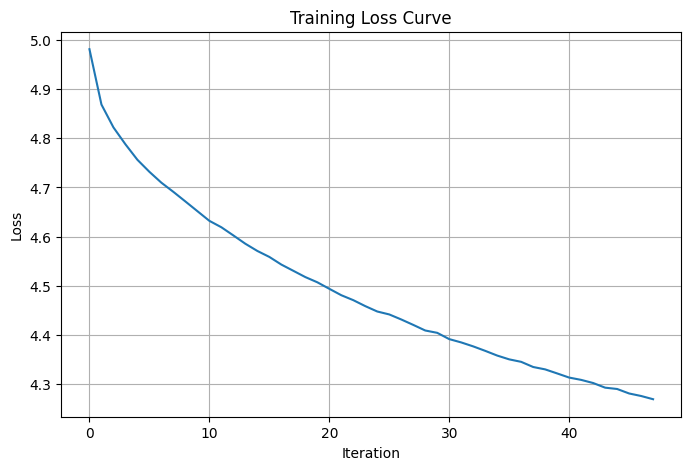

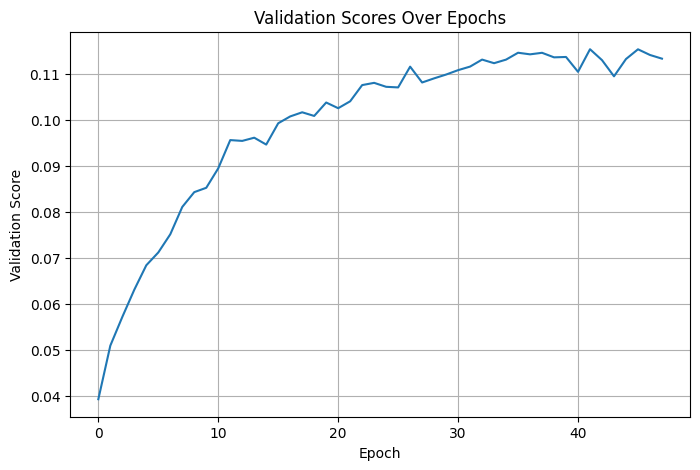

In [55]:
# ---- LOSS CURVE ----
plt.figure(figsize=(8, 5))
plt.plot(model.loss_curve_)
plt.title("Training Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# ---- VALIDATION SCORES ----
plt.figure(figsize=(8, 5))
plt.plot(model.validation_scores_)
plt.title("Validation Scores Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Validation Score")
plt.grid(True)
plt.show()

In [56]:
y_pred = model.predict(X_test)

r2 = model.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R² Score:", r2)
print("MAE:", mae)
print("MSE:", mse)

R² Score: 0.07723579111136147
MAE: 1.705177696100658
MSE: 17.50830294655964


In [ ]:
# Could be better, but not bad for a first try
results = pd.DataFrame(data={"y_test": y_test, "y_pred": y_pred}).sort_values(by="y_test")
results

,y_test,y_pred
77057,1,1.172057
77065,1,1.728270
77066,1,1.539551
77068,1,1.857132
77070,1,1.706599
...,...,...
87312,98,3.730989
89902,104,3.291071
85414,106,4.878818
85682,110,5.424803
